# **Maestría en Inteligencia Artificial Aplicada**

## Curso: **Procesamiento de Lenguaje Natural**

### Tecnológico de Monterrey

### Prof Luis Eduardo Falcón Morales

## Actividad Semana 5

### **Vectores Embebidos de OpenAI**

#### **Nombres y matrículas de los integrantes del equipo:**
JORGE ANDRÉS MOYA PACHECO - A00813287

CARLOS DANIEL PACHECO PEREZ - A01566821

OSCAR NAVA JIMÉNEZ - A01745524

ANUAR OLMOS LÓPEZ - A01092551



In [1]:
!pip install Cython --install-option="--no-cython-compile"
!pip install fasttext
!pip install openai tqdm

# Aquí deberás incluir todas las librerías que requieras durante esta actividad:

import pandas as pd
import numpy as np

import re
import string
import spacy

#Libreria para bajar stopwords en varios idiomas
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

#Libreria para el diccionario
from collections import Counter

#librerias para Huggingface
import torch
from google.colab import userdata
from huggingface_hub import login
from transformers import pipeline

#Librerias para  fasttext


from google.colab import userdata
from openai import OpenAI
import openai


from tqdm import tqdm

#librerias para usar fasttext
import fasttext
import fasttext.util


#Libreria para guardar diccionaro
import pickle

#librerias para regresión lineal bosque aleatorio
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#libreria para calcular más métricas
from sklearn.metrics import classification_report

#librería para obtener matriz de confusión
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Libreria para graficar
import matplotlib.pyplot as plt


#Libreria  para trabajar con directorio
import os

#Libreria para trabajar con google drive
from google.colab import drive # libreria para usar drive

#Comando para abrir archivos de Colab
drive.mount('/content/drive/')


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --install-option


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# **Pregunta - 1:**



Descarga los 3 archivos de Canvas y genera un nuevo DataFrame de Pandas con ellos.

**Llama simplemente "df" a dicho DataFrame.**

Los archivos los encuentras en Canvas: amazon5.txt, imdb5.txt, yelp5.txt.



In [2]:

# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********


dfa = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MNA/NLP/Actividad_3/amazon5.txt', sep='\t', names=['review','label'], header=None, encoding='utf-8')

dfy = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MNA/NLP/Actividad_3/yelp5.txt', sep='\t', names=['review','label'], header=None, encoding='utf-8')

#dfi = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MNA/NLP/Actividad_3/imdb5.txt', delimiter='\t', names=['review','label'], header=None, encoding='utf-8')
dfi = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MNA/NLP/Actividad_3/imdb5.txt',
                  sep=r'\s{3,}',
                  names=['review', 'label'],
                  header=None,
                  engine='python',
                  encoding='utf-8')


df = pd.concat([dfa, dfi, dfy], ignore_index=True)


# *********** Aquí termina la sección de agregar código *************


In [3]:
# Verifiquemos la información del DataFrame:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  3000 non-null   object
 1   label   3000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 47.0+ KB


In [4]:
# Y veamos sus primeros registros:

df.head()

,review,label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


# **Pregunta - 2:**

Realiza el proceso de limpieza. Aplica el preprocesamiento que consideres adecuado.











In [21]:

# ********** Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********



# Descargar recursos si no lo has hecho
nltk.download('stopwords')

# Cargar modelo de spaCy en inglés
nlp = spacy.load("en_core_web_sm")

# Stopwords en inglés
stop_words = set(stopwords.words("english"))

def clean_tok(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)  # eliminar puntuación y números
    text = re.sub(r'\s+', ' ', text).strip()  # eliminar espacios múltiples

    # Procesamiento con spaCy
    doc = nlp(text)

    # Lematización y filtrado
    tokens = [token.lemma_ for token in doc if token.lemma_ not in stop_words and len(token.lemma_) > 2]

    return tokens

X=df['review']

# Aplicamos limpieza
Xclean = X.apply(clean_tok)

# Etiquetas
Y = df['label']

# *********** Aquí termina la sección de agregar código *************


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Despleguemos los primeros comentarios después de tu proceso de limpieza:

for x in Xclean[0:5]:
  print(x)


['way', 'plug', 'unless', 'converter']
['good', 'case', 'excellent', 'value']
['great', 'jawbone']
['tie', 'charger', 'conversation', 'last', 'minute', 'major', 'problem']
['mic', 'great']


# **Pregunta - 3:**



Realicemos una partición aleatoria con los mismos porcentajes de la práctica pasada para poder comparar dichos resultados con los de
esta actividad, a saber, 70%, 15% y 15%, para entrenamiento, validación y prueba, respectivamente.

In [7]:

# ************* Inicia la sección de agregar código:*****************************

from sklearn.model_selection import train_test_split

x_train, x_val_and_test, y_train, y_val_and_test = train_test_split(Xclean, Y, train_size=.70, shuffle=True, random_state=1)
x_val, x_test, y_val, y_test = train_test_split(x_val_and_test, y_val_and_test, test_size=.50, shuffle=True, random_state=17)



# *********** Termina la sección de agregar código *************


# verificemos las dimensiones obtenidas:
print('X,y Train:', len(x_train), len(y_train))
print('X,y Val:', len(x_val), len(y_val))
print('X,y Test', len(x_test), len(y_test))

X,y Train: 2100 2100
X,y Val: 450 450
X,y Test 450 450


# **Pregunta - 4:**



Construye tu vocabulario a continuación


**Justificación**

Al construir un diccionario para modelos de procesamiento de lenguaje natural se recomienda excluir palabras con baja frecuencia y pocos caracteres debido a que lass palabras de baja frecuencia suelen incluir:

* Errores tipográficos.
* Palabras mal formadas o incompletas.
* Términos irrelevantes o específicos de un único contexto (outliers).

Además tener un vocabulario muy grande aumenta la complejidad computacional, eleva el uso de memoria y puede provocar dispersión en representaciones como bag-of-words o one-hot encoding.

Es por lo anterior que se decidió eliminar las palabras con un baja frecuencia y pocos caracteres.

In [9]:
# a.	Usa el conjunto de entrenamiento para generar tu vocabulario
#     con un tamaño que consideres adecuado:


# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********

midiccionario = Counter()

for k in range(len(x_train)):
    midiccionario.update(x_train.iloc[k])  # ← aquí está la corrección

min_freq = 2
midicc = {}

for word in midiccionario.items():
    if word[1] >= min_freq:
        midicc.update({word[0]: word[1]})

print('\n(word,frequency):')

diccionario_ordenado = sorted(midicc.items(), key=lambda x: x[1], reverse=True)

n = 10  # Por ejemplo, los 10 más frecuentes
for token, frecuencia in diccionario_ordenado[:n]:
    print(f"{token}: {frecuencia}")


# *********** Aquí termina la sección de agregar código *************


(word,frequency):
good: 213
great: 141
movie: 140
phone: 134
film: 130
work: 112
bad: 111
well: 102
like: 101
time: 101


In [10]:
# b.	Indica el tamaño del vocabulario generado.

print('Longitud del vocabulario generado:')


# ******* Inicia la sección de agregar código: ***********

print(len(midicc))


# *********** Aquí termina la sección de agregar código *************

Longitud del vocabulario generado:
1410


c.	¿Por qué debe usarse solamente el conjunto de entrenamiento para generar el vocabulario?


### ++++++++ Inicia la sección de agregar texto: +++++++++++

Se debe usar solo el conjunto de entrenamiento, ya que hacerlo con el conjunto de prueba o validación puede provocar data leakage, es decir, el modelo obtiene información adicional que no debería tener durante el entrenamiento. Además, para una evaluación realista, el conjunto de prueba debe mantenerse completamente aislado del proceso de entrenamiento, simulando condiciones reales de puesta en marcha, donde el modelo no conoce previamente los datos con los que se enfrentará.


### ++++++++ Termina la sección de agregar texto: +++++++++++


In [11]:
# d.	Con el vocabulario generado, filtra los conjuntos de entrenamiento,
#     validación y prueba para que todos los comentarios usen solamente las
#     palabras de este vocabulario.

#     Llamar train_x, val_x y test_x a estos tres conjuntos.


# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********


train_x1 = []
for ss in x_train:
  train_x1.append([w for w in ss if w in midicc])

val_x1 = []
for ss in x_val:
  val_x1.append([w for w in ss if w in midicc])

test_x1 = []
for ss in x_test:
  test_x1.append([w for w in ss if w in midicc])


# *********** Aquí termina la sección de agregar código *************


In [12]:
# Vemos el resultado de los primeros comentarios del conjunto de entrenamiento:

for ss in train_x1[0:5]:
  print(ss)

['star', 'fare', 'much', 'well', 'people', 'like', 'morgan', 'waste']
['tonight', 'filet', 'special', 'suck']
['pay', 'bill', 'tip', 'feel', 'server', 'terrible', 'job']
['call', 'properly', 'cook', 'steak', 'understand']
['however', 'keypad', 'tinny', 'sometimes', 'reach', 'wrong', 'button']


# **Pregunta - 5:**


#### **Incluye aquí un resumen de las características y diferencias que tiene al menos los tres modelos de OpenAI indicados: "text-embedding-3-small", "text-embedding-3-large" y "text-embedding-ada-002".**

### ++++++++ Inicia la sección de agregar texto: +++++++++++

OpenAI ofrece varios modelos de generación de vectores embebidos que convierten texto en representaciones numéricas útiles para tareas de análisis semántico.

* **Text-embedding-3-small** destaca por su bajo costo, buena precisión y velocidad.

Dimensión: 1,536 dimensiones.

Tamaño del modelo: Pequeño.

Precio: 62,500 páginas por dólar

*  **Text-embedding-3-large** brinda mayor precisión y profundidad semántica, recomendado para tareas más exigentes.

Dimensión: 3,072 dimensiones.

Tamaño del modelo: Grande.

Precio: 9,615 páginas por dólar

*  **text-embedding-ada-00**2 fue el modelo estándar anterior, ahora superado en rendimiento.

Dimensión: 1,536 dimensiones.

Tamaño del modelo: Más antiguo y menos potente.

Precio: 12,500 páginas por dólar

Estos modelos permiten representar comentarios o documentos como vectores de alta dimensión para su uso en modelos de machine learning y clasificación (OpenAI, 2024).


Referencia bibliográfica:

OpenAI. (2024). OpenAI API documentation: Embeddings. https://platform.openai.com/docs/guides/embeddings




### ++++++++ Termina la sección de agregar texto: +++++++++++


# **Pregunta - 6:**


#### **Diccionario clave-valor de palabras del diccionario y vectores embebidos.**

In [13]:
# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********

# SEBE CREAR EL SECRETO EN EL SIMBOLO DE LA LLAVE, INTRUDICR LA LLAVE NO SIRVE
api_key1 = userdata.get("asdf")

if not api_key1:
  raise ValueError("API key no encontrada en los secretos")


# Configura tu clave de API
client = OpenAI(api_key = api_key1)

# Diccionario para almacenar los vectores
nuevo_diccionario = {}
tokens_usados = 0

for palabra in tqdm(midicc, desc="Generando vectores embebidos"):
    try:
      response = client.embeddings.create(
            model="text-embedding-3-small",
            input=palabra)

      vector = response.data[0].embedding
      nuevo_diccionario[palabra] = vector
      tokens_usados += response.usage.total_tokens
    except Exception as e:
        print(f"Error con la palabra '{palabra}': {e}")

# Guardamos el diccionario
with open("diccionario_vectores.pkl", "wb") as f:
    pickle.dump(nuevo_diccionario, f)

# Mensajes finales
print(f"\n Diccionario guardado con {len(nuevo_diccionario)} vectores.")
print(f" Tokens totales usados: {tokens_usados}")


# *********** Aquí termina la sección de agregar código *************


Generando vectores embebidos: 100%|██████████| 1410/1410 [05:40<00:00,  4.15it/s]


 Diccionario guardado con 1410 vectores.
 Tokens totales usados: 2066


In [14]:
print(f"Costo estimado: ${tokens_usados * 0.02 / 1_000_000:.6f} USD")

Costo estimado: $0.000041 USD


**Costo del modelo**

El modelo "text-embedding-3-small" tiene un costo de $0.02 USD por cada millón de tokens. Se eligió por ser económico, lo que lo hace adecuado para tareas a gran escala que requieren generar vectores embebidos a bajo costo.

Para obtener los vectores embebidos del conjunto de entrenamiento, se usaron 2365 tokens, lo que representa un costo estimado de $0.000041 USD.

# **Pregunta - 7:**



Generamos los vectores embebidos a partir de los conjuntos de entrenamiento, validación y prueba.

Los llamaremos trainEmb, valEmb y testEmb, respectivamente.

In [15]:
# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********


#Función para promediar vectores embebidos
def promedio_vectores(enunciados):
  enunciados_vector_promedio=[]
  for enunciado in enunciados:
    vectores=[]
    for palabra in enunciado:
      if palabra in nuevo_diccionario:
        vectores.append(nuevo_diccionario[palabra])

    if vectores:
      vector_promedio = np.mean(vectores, axis=0)
    else:
      vector_promedio = np.zeros(1536)

    enunciados_vector_promedio.append(vector_promedio)

  return enunciados_vector_promedio # se tiene que convertir a array, las listas no tienen el atributo shape

#Se establece ruta del diccionario guardado previamente
ruta = "/content/drive/MyDrive/Colab Notebooks/MNA/NLP/Actividad_3/diccionario_vectores.pkl"

#Se abre diccionario de vectores embebidos
with open(ruta, "rb") as f:
    nuevo_diccionario = pickle.load(f)

trainEmb = np.array(promedio_vectores(train_x1))
valEmb = np.array(promedio_vectores(val_x1))
testEmb = np.array(promedio_vectores(test_x1))

# *********** Aquí termina la sección de agregar código *************

In [16]:
# Veamos las dimensiones de cada conjunto embebido:

print("Train-Emb:", trainEmb.shape)
print("Val-Emb:", valEmb.shape)
print("Test-Emb:", testEmb.shape)



Train-Emb: (2100, 1536)
Val-Emb: (450, 1536)
Test-Emb: (450, 1536)


# **Pregunta - 8:**



Utiliza los modelos de regresión logística y bosque aleatorio (random forest) y encuentra sus desempeños.

Compara los resultados con los de la semana anterior.

In [42]:
# REGRESIÓN LOGÍSTICA:

# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********
# trainEMb,y_train/valEMb,y_val/testEMb,y_test

modeloLRcount = LogisticRegression(max_iter=200, C=7, penalty = 'l2', solver= 'liblinear')
modeloLRcount.fit(trainEmb, y_train)

print('LR: Train-accuracy: %.2f%%' % (100*modeloLRcount.score(trainEmb, y_train)))
print('LR: Val-accuracy: %.2f%%' % (100*modeloLRcount.score(valEmb, y_val)))

y_pred3 = modeloLRcount.predict(trainEmb)

print('\n Reporte de sklearn de Train')
print(classification_report(y_train, y_pred3))

y_pred4 = modeloLRcount.predict(valEmb)

print('\n Reporte de sklearn de Val')
print(classification_report(y_val, y_pred4))

# *********** Aquí termina la sección de agregar código *************


LR: Train-accuracy: 83.71%
LR: Val-accuracy: 79.78%

 Reporte de sklearn de Train
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1068
           1       0.84      0.82      0.83      1032

    accuracy                           0.84      2100
   macro avg       0.84      0.84      0.84      2100
weighted avg       0.84      0.84      0.84      2100


 Reporte de sklearn de Val
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       216
           1       0.80      0.82      0.81       234

    accuracy                           0.80       450
   macro avg       0.80      0.80      0.80       450
weighted avg       0.80      0.80      0.80       450



**Comparativo semana anterior usando Regresión Logística**

Usando el modelo de regresión logistica se obtuvo un "accuracy" del 83.71% para el conjunto de entrenamiento y 79.78% para el conjunto de validación, lo que significa que el modelo generaliza bien y no esta sobreentrenado.

En la actividad de la semana usando un modelo de regresión logística y las matrioces dispersas TF-IDF se obtuvo "accuracy" del 78.68%, lo que es ligeramente menor al resultado obtenido usando vector embebidos promedio de cada enunciado 79.78%%.

In [89]:
# BOSQUE ALEATORIO (Random Forest):

# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********

modeloRFcount = RandomForestClassifier(n_estimators=100,  #  si sube de 100 mejora la exactitud solo en train
                                       max_depth=2,    #Si se sube la profundidad arriba de 10 no mejora
                                       min_samples_split=100, # el minimo para dividir son 2, arriba de 100 no mejora
                                       min_samples_leaf=6,  # arriba de 6 cae la exactitud
                                       max_features='log2',
                                       random_state=42)
modeloRFcount.fit(trainEmb, y_train)

print('\nRF: Train-accuracy: %.2f%%' % (100*modeloRFcount.score(trainEmb, y_train)))
print('RF: Val-accuracy: %.2f%%' % (100*modeloRFcount.score(valEmb, y_val)))


y_pred = modeloRFcount.predict(trainEmb)

print('\n Reporte de sklearn de Train')
print(classification_report(y_train, y_pred))

y_pred2 = modeloRFcount.predict(valEmb)

print('\n Reporte de sklearn de Val')
print(classification_report(y_val, y_pred2))

# *********** Aquí termina la sección de agregar código *************


RF: Train-accuracy: 80.19%
RF: Val-accuracy: 77.11%

 Reporte de sklearn de Train
              precision    recall  f1-score   support

           0       0.77      0.88      0.82      1068
           1       0.85      0.72      0.78      1032

    accuracy                           0.80      2100
   macro avg       0.81      0.80      0.80      2100
weighted avg       0.81      0.80      0.80      2100


 Reporte de sklearn de Val
              precision    recall  f1-score   support

           0       0.71      0.87      0.78       216
           1       0.85      0.68      0.76       234

    accuracy                           0.77       450
   macro avg       0.78      0.77      0.77       450
weighted avg       0.79      0.77      0.77       450



**Comparativo semana anterior usando Random Forest**

Usando el modelo de bosque aleatorio se obtuvo un "accuracy" del 80.19% para el conjunto de entrenamiento y 77.11% para el conjunto de validación, lo que significa que el modelo generaliza bien, no esta sobreentrenado, pero se tiene un resultado ligeramente inferior al obtenido con el modelo de regresión lineal.

Este resultado, 77.11% es ligeramente inferior al de la semana pasada usando Random Forest y las matrioces dispersas TF-IDF en el que se obtuvo un "accuracy" del 78.56%.

# **Pregunta - 9:**



Reporte del mejor modelo con el conjunto de Prueba (Test).


LR: Test-accuracy: 80.22%

 Reporte de sklearn de Val
              precision    recall  f1-score   support

           0       0.79      0.80      0.79       216
           1       0.81      0.81      0.81       234

    accuracy                           0.80       450
   macro avg       0.80      0.80      0.80       450
weighted avg       0.80      0.80      0.80       450



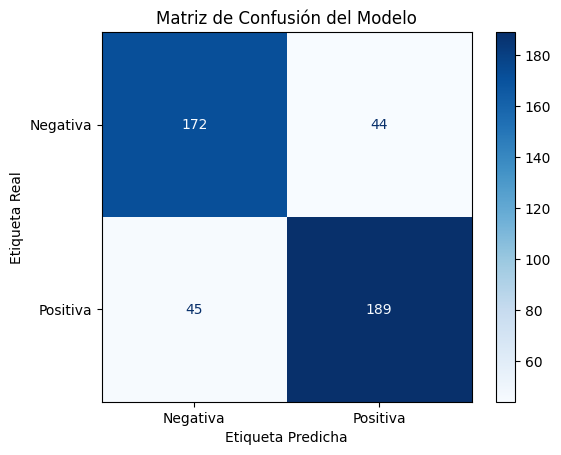

In [91]:
# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********


print('LR: Test-accuracy: %.2f%%' % (100*modeloLRcount.score(testEmb, y_test)))

y_pred5 = modeloLRcount.predict(testEmb)

print('\n Reporte de sklearn de Val')
print(classification_report(y_test, y_pred5))

cm = confusion_matrix(y_test, y_pred5, labels=[0, 1])

# Visualizarla con etiquetas
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negativa', 'Positiva'])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión del Modelo')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')
plt.show()

# *********** Aquí termina la sección de agregar código *************

**Mejor modelo**

Se utilizó un modelo de regresión logística que alcanzó un accuracy del 80.22% en el conjunto de prueba, lo cual indica buen rendimiento y adecuada generalización sin signos de sobreajuste. La matriz de confusión mostró 172 verdaderos negativos y 189 verdaderos positivos, con 44 falsos positivos y 45 falsos negativos, lo que sugiere errores en ambas clases. El reporte de scikit-learn reflejó métricas equilibradas: precisión, recall y F1-score cercanas a 0.80 para ambas clases. En general, el modelo es preciso y balanceado, aunque todavía hay área de oportunidad para reducir los errores de clasificación.


# **Pregunta - 10:**

In [22]:
# Se asegura que X sean strings
enunciados = X.astype(str)

# Diccionario para almacenar los vectores de los enunciados
vectores_enunciados = {}
tokens_usados = 0

for i, texto in tqdm(enumerate(enunciados), total=len(enunciados), desc="Generando embeddings de enunciados"):
    try:
        response = client.embeddings.create(
            model="text-embedding-3-small",
            input=texto
        )
        vector = response.data[0].embedding
        vectores_enunciados[i] = vector
        tokens_usados += response.usage.total_tokens
    except Exception as e:
        print(f"Error con el enunciado {i}: {e}")
        vectores_enunciados[i] = None  # para mantener el orden

# Convertir a array numpy, ignorando los que fallaron
embedding_array = np.array([vectores_enunciados[i] for i in range(len(enunciados)) if vectores_enunciados[i] is not None])

# Se guarda el diccionario para no tener que volverlo a cargar
with open("embeddings_enunciados.pkl", "wb") as f:
    pickle.dump(embedding_array, f)

# Mensajes finales
print(f"\n Embeddings guardados para {len(embedding_array)} enunciados.")
print(f" Tokens totales usados: {tokens_usados}")

Generando embeddings de enunciados: 100%|██████████| 3000/3000 [13:07<00:00,  3.81it/s]



 Embeddings guardados para 3000 enunciados.
 Tokens totales usados: 43804


In [23]:
print(f"Costo estimado: ${tokens_usados * 0.02 / 1_000_000:.6f} USD")

Costo estimado: $0.000876 USD


In [24]:
#Se establece ruta del diccionario guardado previamente
ruta = "/content/drive/MyDrive/Colab Notebooks/MNA/NLP/Actividad_3/embeddings_enunciados.pkl"

#Se abre diccionario de vectores embebidos de enunciados
with open(ruta, "rb") as f:
    embedding_array = pickle.load(f)



In [25]:
# Primera división: entrenamiento (70%) y validación+test (30%)
X_train_embed, X_val_and_test_embed, y_train2, y_val_and_test2 = train_test_split(
    embedding_array, Y, train_size=0.70, shuffle=True, random_state=1
)

# Segunda división: validación (15%) y test (15%)
X_val_embed, X_test_embed, y_val2, y_test2 = train_test_split(
    X_val_and_test_embed, y_val_and_test2, test_size=0.50, shuffle=True, random_state=17
)

# Verificación
print("Embeddings Train:", X_train_embed.shape)
print("Embeddings Val:  ", X_val_embed.shape)
print("Embeddings Test: ", X_test_embed.shape)

Embeddings Train: (2100, 1536)
Embeddings Val:   (450, 1536)
Embeddings Test:  (450, 1536)


In [26]:
# REGRESIÓN LOGÍSTICA:

# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********
# trainEMb,y_train/valEMb,y_val/testEMb,y_test

modeloLRcount = LogisticRegression(max_iter=200, C=6, penalty = 'l2', solver= 'liblinear')
modeloLRcount.fit(X_train_embed, y_train)

print('LR: Train-accuracy: %.2f%%' % (100*modeloLRcount.score(X_train_embed, y_train)))
print('LR: Val-accuracy: %.2f%%' % (100*modeloLRcount.score(X_val_embed, y_val)))

y_pred3 = modeloLRcount.predict(X_train_embed)

print('\n Reporte de sklearn de Train')
print(classification_report(y_train, y_pred3))

y_pred4 = modeloLRcount.predict(X_val_embed)

print('\n Reporte de sklearn de Val')
print(classification_report(y_val, y_pred4))

# *********** Aquí termina la sección de agregar código *************


LR: Train-accuracy: 99.10%
LR: Val-accuracy: 97.56%

 Reporte de sklearn de Train
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1068
           1       0.99      0.99      0.99      1032

    accuracy                           0.99      2100
   macro avg       0.99      0.99      0.99      2100
weighted avg       0.99      0.99      0.99      2100


 Reporte de sklearn de Val
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       216
           1       0.97      0.98      0.98       234

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



In [27]:
# BOSQUE ALEATORIO (Random Forest):

# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********

modeloRFcount = RandomForestClassifier(n_estimators=100,  #  si sube de 100 mejora la exactitud solo en train
                                       max_depth=3,    #Si se sube la profundidad arriba de 10 no mejora
                                       min_samples_split=100, # el minimo para dividir son 2, arriba de 100 no mejora
                                       min_samples_leaf=6,  # arriba de 6 cae la exactitud
                                       max_features='log2',
                                       random_state=42)
modeloRFcount.fit(X_train_embed, y_train)

print('\nRF: Train-accuracy: %.2f%%' % (100*modeloRFcount.score(X_train_embed, y_train)))
print('RF: Val-accuracy: %.2f%%' % (100*modeloRFcount.score(X_val_embed, y_val)))


y_pred = modeloRFcount.predict(X_train_embed)

print('\n Reporte de sklearn de Train')
print(classification_report(y_train, y_pred))

y_pred2 = modeloRFcount.predict(X_val_embed)

print('\n Reporte de sklearn de Val')
print(classification_report(y_val, y_pred2))

# *********** Aquí termina la sección de agregar código *************



RF: Train-accuracy: 98.10%
RF: Val-accuracy: 96.22%

 Reporte de sklearn de Train
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1068
           1       0.97      0.99      0.98      1032

    accuracy                           0.98      2100
   macro avg       0.98      0.98      0.98      2100
weighted avg       0.98      0.98      0.98      2100


 Reporte de sklearn de Val
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       216
           1       0.97      0.96      0.96       234

    accuracy                           0.96       450
   macro avg       0.96      0.96      0.96       450
weighted avg       0.96      0.96      0.96       450



**Mejor modelo**

A continuación se muestra el resultado de "accuracy" con el conjunto de prueba usando el mejor modelo encontrado, el cual fue el de regresión logística.

LR: Test-accuracy: 97.78%

 Reporte de sklearn de Val
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       216
           1       0.98      0.98      0.98       234

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



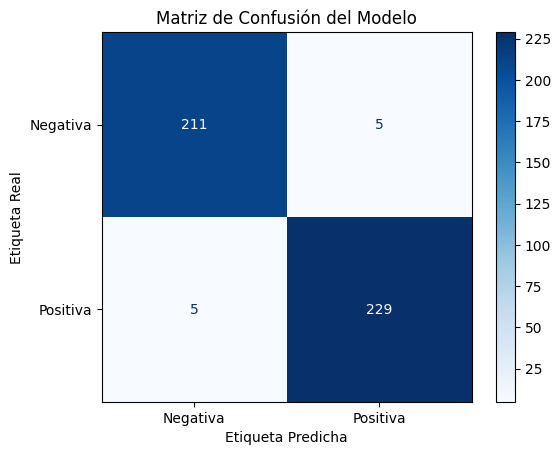

In [28]:
# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********


print('LR: Test-accuracy: %.2f%%' % (100*modeloLRcount.score(X_test_embed, y_test)))

y_pred5 = modeloLRcount.predict(X_test_embed)

print('\n Reporte de sklearn de Val')
print(classification_report(y_test, y_pred5))

cm = confusion_matrix(y_test, y_pred5, labels=[0, 1])

# Visualizarla con etiquetas
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negativa', 'Positiva'])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión del Modelo')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')
plt.show()

# *********** Aquí termina la sección de agregar código *************

Se observa que este modelo clasifica mucho mejor los enunciados, ya que la mayoría de las predicciones fueron correctas y solo existen 5 falsos positivos y 5 falsos negativos, por lo que supera con creces el modelo anterior que usó vectores embebidos de cada token en vez de vectores embebidos por enunciado

# **Pregunta - 11:**



Incluye tus comentarios finales de la actividad.

### ++++++++ Inicia la sección de agregar texto: +++++++++++

En esta actividad se entrenaron modelos utilizando regresión logística y bosque aleatorio, empleando en la primera parte vectores embebidos promedios de los tokens de cada enunciado, y en la segunda parte, vectores embebidos de comentarios completos. Estos vectores se obtuvieron mediante la API de OpenAI, usando el modelo text-embedding-3-small, el cual es económico, rápido y eficiente para procesar grandes volúmenes de datos.

El mejor modelo con vectores embebidos por tokens fue la regresión logística, con un accuracy del 80.22%, superando el resultado obtenido anteriormente con regresión logística y matrices dispersas TF-IDF (78.68%).

Al utilizar vectores embebidos a nivel de enunciado, se alcanzó un accuracy del 97.78%, superando ampliamente el resultado con vectores promedio de tokens (80.22%). Esta mejora se debe a que el procesamiento a nivel de comentario completo captura mejor el contexto semántico que el enfoque palabra por palabra.

### ++++++++ Termina la sección de agregar texto: +++++++++++

# **Fin de la Actividad de Vectores Embebidos - OpenAI**